In [41]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve

In [42]:
#ped_file = '../../DATA/spark/spark.ped'
#phase_dir = '../phased_spark_del'

ped_file = '../../DATA/ihart.v34/ihart.ped'
phase_dir = '../phased_ihart.v34_del'

In [43]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            #if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                #child_id = ssc_old_id_to_new_id[child_id]
                #f_id = ssc_old_id_to_new_id[f_id]
                #m_id = ssc_old_id_to_new_id[m_id]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if f_id != '0' and m_id != '0':
                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [44]:
with open('%s/deletions.json' % phase_dir) as f:
    deletions = json.load(f)

In [45]:
# filter deletions
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

chroms = [str(x) for x in range(1, 23)]
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
with open('filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
full_deletions = [d for i, d in enumerate(deletions) if i not in excluded_deletions]
print('remaining deletions', len(deletions))

remaining deletions 128621
remaining deletions 128621
excluded deletions 53984
remaining deletions 128621


In [46]:
deletions = []
notrans_deletions = []
fam_to_num_bases = defaultdict(int)
fam_to_num_dels = defaultdict(int)
fam_to_size = dict([(x[0], len(v)) for x, v in fam_to_inds.items()])

for d in full_deletions:
    if d['is_inherited'] and d['family_size']>=4 and fam_to_size[d['family']] == d['family_size']:
        for child in d['trans']:
            deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        for child in d['notrans']:
            notrans_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        assert fam_to_size[d['family']] == d['family_size']
                
        fam_to_num_bases[d['family']] += d['length']
        fam_to_num_dels[d['family']] += 1

In [47]:
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))

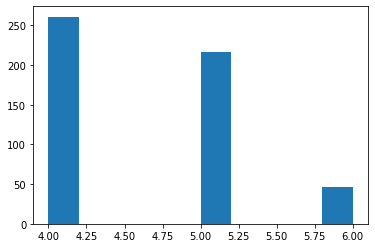

In [48]:
plt.hist([fam_to_size[x] for x in families])
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


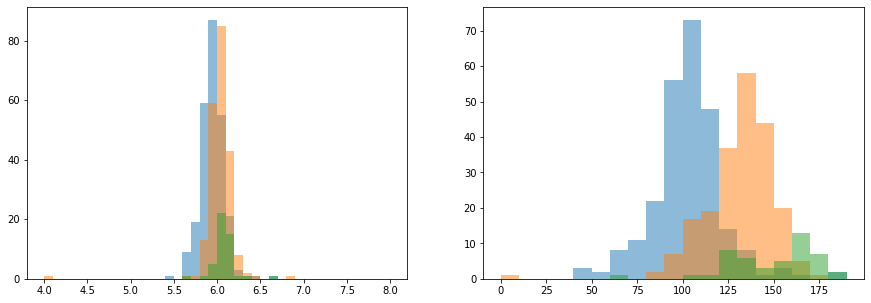

In [49]:
plt.figure(figsize=(15, 5))
for i in range(4, 7):
    plt.subplot(1, 2, 1)
    plt.hist([np.clip(np.log10(fam_to_num_bases[x]), 4, 8) for x in families if fam_to_size[x]==i], alpha=0.5, bins=np.arange(4, 8.1, 0.1))
    plt.subplot(1, 2, 2)
    plt.hist([np.clip(fam_to_num_dels[x], 0, 200) for x in families if fam_to_size[x]==i], alpha=0.5, bins=np.arange(0, 200, 10))
plt.show()

In [50]:
with open('%s/individuals.json' % phase_dir) as f:
    individuals = set(json.load(f))
    
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))
    
children = set()
for fam, inds in fam_to_inds.items():
    #print(fam, inds)
    if fam[0] in families and len(inds)>3:
        children.update([x for x in inds[2:] if x in individuals])
    
assert np.all(x in in_ped for x in individuals)
child_to_index = dict([(x, i) for i, x in enumerate(children)])

print(len(individuals), len(children))

2405 1357


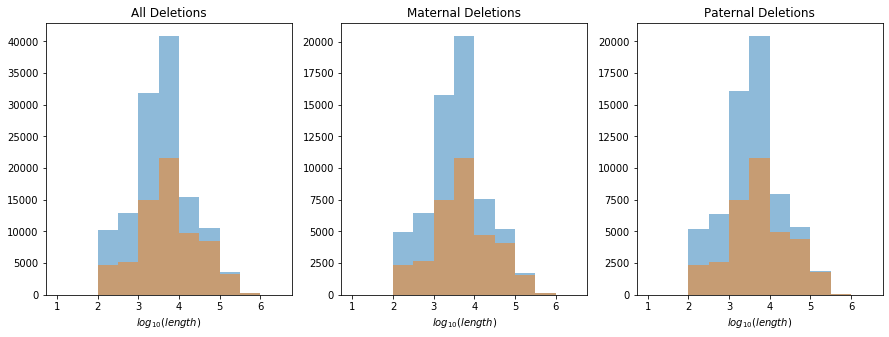

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 2)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 3)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.show()

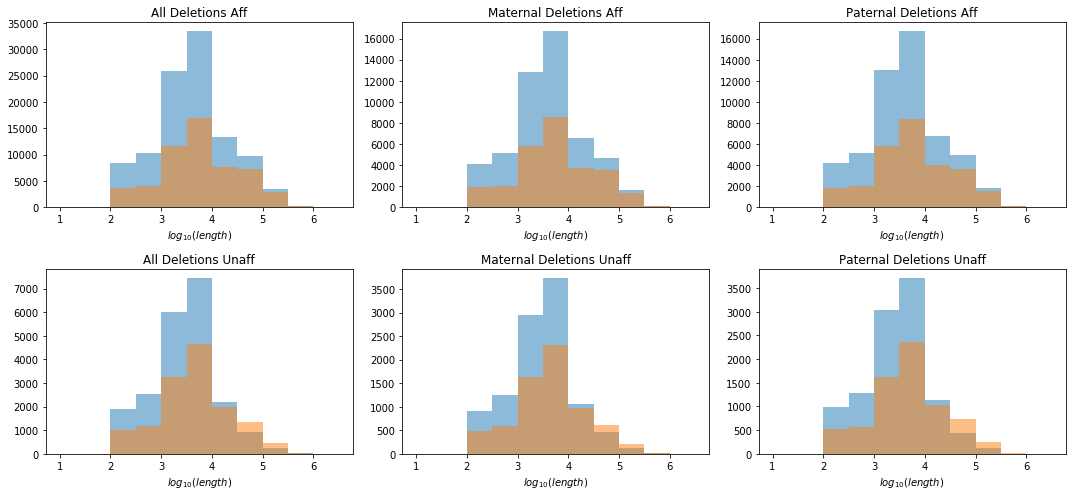

In [52]:
plt.figure(figsize=(15, 7))
plt.subplot(2, 3, 1)
aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2'], bins=np.arange(1, 7, 0.5), alpha=0.5)
aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2'], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 2)
mat_aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
mat_aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 3)
pat_aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
pat_aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 4)
unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1'], bins=np.arange(1, 7, 0.5), alpha=0.5)
unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1'], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 5)
mat_unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
mat_unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 6)
pat_unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
pat_unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.tight_layout()
plt.show()

In [53]:
print(len(deletions), 
      len([x for x in deletions if x['is_mat']]),
     len([x for x in deletions if x['is_pat']]))

125639 62255 63384


In [54]:
num_deletions = np.zeros((len(children),))
num_notrans_deletions = np.zeros((len(children),))
mat_num_deletions = np.zeros((len(children),))
mat_num_notrans_deletions = np.zeros((len(children),))
pat_num_deletions = np.zeros((len(children),))
pat_num_notrans_deletions = np.zeros((len(children),))

num_bases = np.zeros((len(children),))
num_notrans_bases = np.zeros((len(children),))
mat_num_bases =np.zeros((len(children),))
mat_num_notrans_bases = np.zeros((len(children),))
pat_num_bases = np.zeros((len(children),))
pat_num_notrans_bases = np.zeros((len(children),))

for d in deletions:
    child_index = child_to_index[d['child']]
    num_deletions[child_index] += 1
    num_bases[child_index] += d['length']
    if d['is_mat']:
        mat_num_deletions[child_index] += 1
        mat_num_bases[child_index] += d['length']
    if d['is_pat']:
        pat_num_deletions[child_index] += 1
        pat_num_bases[child_index] += d['length']
    
for d in notrans_deletions:
    child_index = child_to_index[d['child']]
    num_notrans_deletions[child_index] += 1
    num_notrans_bases[child_index] += d['length']
    if d['is_mat']:
        mat_num_notrans_deletions[child_index] += 1
        mat_num_notrans_bases[child_index] += d['length']
    if d['is_pat']:
        pat_num_notrans_deletions[child_index] += 1
        pat_num_notrans_bases[child_index] += d['length']

In [55]:
print([x for i, x in enumerate(children) if num_bases[i]==0])

['AU016203', 'AU016204']


In [56]:
is_aut = np.array([child_id_to_affected[x]=='2' for x in children])
is_nt = np.array([child_id_to_affected[x]=='1' for x in children])

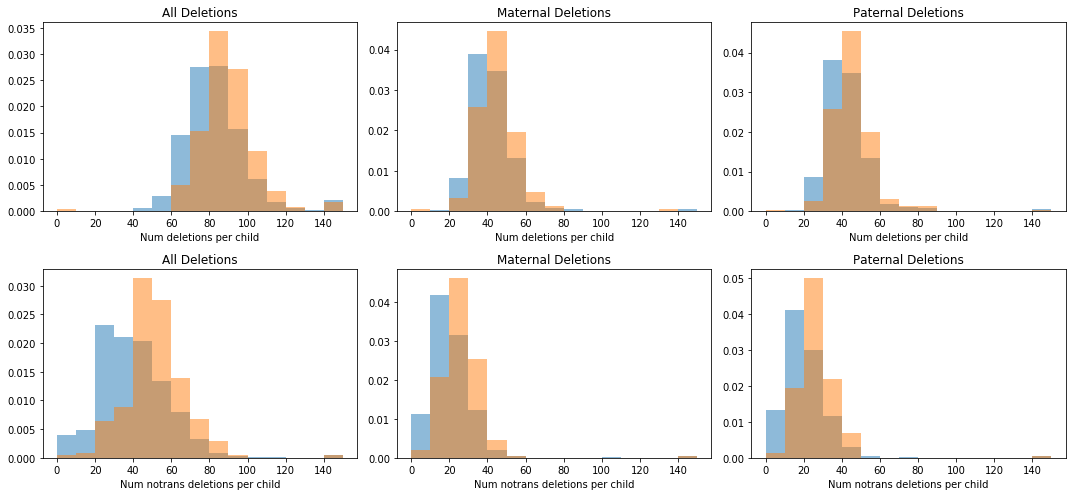

In [57]:
plt.figure(figsize=(15, 7))

bins = np.arange(0, 160, 10)
max_clip = 150

plt.subplot(2, 3, 1)
plt.hist(np.clip(num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 2)
plt.hist(np.clip(mat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(mat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 3)
plt.hist(np.clip(pat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(pat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 4)
plt.hist(np.clip(num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num notrans deletions per child')

plt.subplot(2, 3, 5)
plt.hist(np.clip(mat_num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(mat_num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num notrans deletions per child')

plt.subplot(2, 3, 6)
plt.hist(np.clip(pat_num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(pat_num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num notrans deletions per child')


plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Num bases deleted per child')

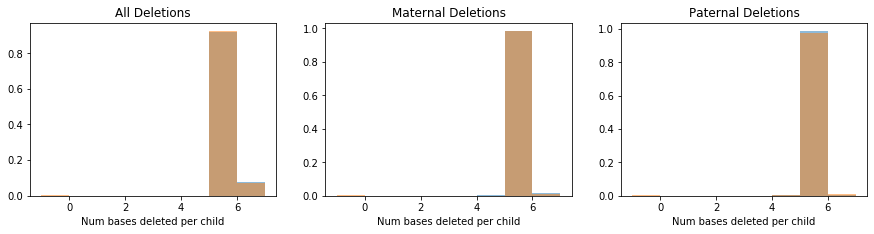

In [58]:
plt.figure(figsize=(15, 7))

bins = np.arange(-1, 8, 1)

plt.subplot(2, 3, 1)
plt.hist(np.clip(np.log10(num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 2)
plt.hist(np.clip(np.log10(mat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(mat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 3)
plt.hist(np.clip(np.log10(pat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(pat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num bases deleted per child')


In [59]:
print(np.sum(is_aut), np.sum(is_nt))

1121 236


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10


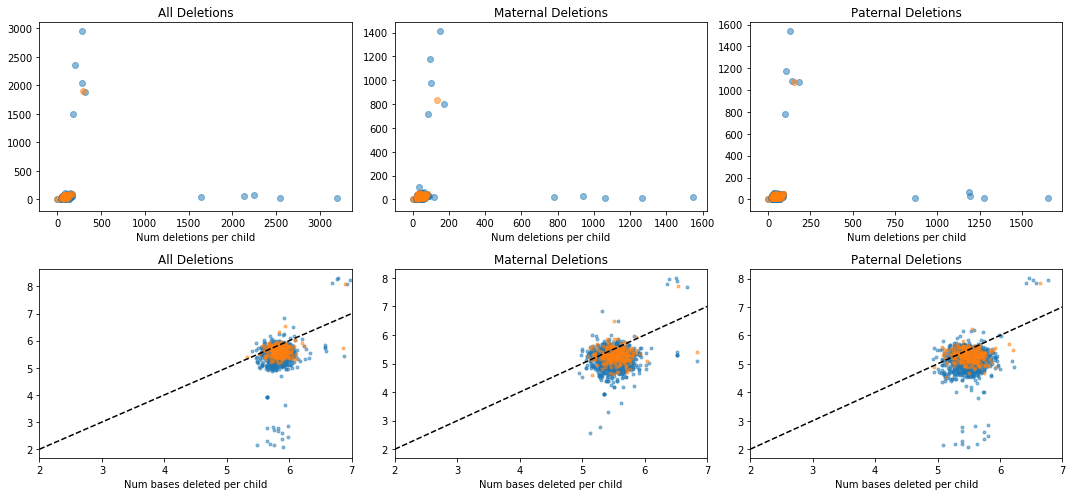

In [60]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
plt.scatter(num_deletions[is_aut], num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(num_deletions[is_nt], num_notrans_deletions[is_nt], alpha=0.5)
plt.title('All Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 2)
plt.scatter(mat_num_deletions[is_aut], mat_num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(mat_num_deletions[is_nt], mat_num_notrans_deletions[is_nt], alpha=0.5)
plt.title('Maternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 3)
plt.scatter(pat_num_deletions[is_aut], pat_num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(pat_num_deletions[is_nt], pat_num_notrans_deletions[is_nt], alpha=0.5)
plt.title('Paternal Deletions')
plt.xlabel('Num deletions per child')

bins = np.arange(0, 8, 0.1)

plt.subplot(2, 3, 4)
plt.scatter(np.log10(num_bases[is_aut]), np.log10(num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(num_bases[is_nt]), np.log10(num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('All Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.subplot(2, 3, 5)
plt.scatter(np.log10(mat_num_bases[is_aut]), np.log10(mat_num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(mat_num_bases[is_nt]), np.log10(mat_num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('Maternal Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.subplot(2, 3, 6)
plt.scatter(np.log10(pat_num_bases[is_aut]), np.log10(pat_num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(pat_num_bases[is_nt]), np.log10(pat_num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('Paternal Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [61]:
print(np.sum(num_bases[is_aut]>num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(num_bases[is_nt]>num_notrans_bases[is_nt])/np.sum(is_nt))
print(stats.chi2_contingency([[np.sum(num_bases[is_aut]>num_notrans_bases[is_aut]), 
                               np.sum(num_bases[is_nt]>num_notrans_bases[is_nt])],
                              [np.sum(num_bases[is_aut]<num_notrans_bases[is_aut]), 
                               np.sum(num_bases[is_nt]<num_notrans_bases[is_nt])],
                             ]))


print(np.sum(mat_num_bases[is_aut]>mat_num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(mat_num_bases[is_nt]>mat_num_notrans_bases[is_nt])/np.sum(is_nt),
      np.sum(pat_num_bases[is_aut]>pat_num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(pat_num_bases[is_nt]>pat_num_notrans_bases[is_nt])/np.sum(is_nt))
print(stats.chi2_contingency([[[np.sum(mat_num_bases[is_aut]>mat_num_notrans_bases[is_aut]), 
                               np.sum(mat_num_bases[is_nt]>mat_num_notrans_bases[is_nt])],
                              [np.sum(mat_num_bases[is_aut]<mat_num_notrans_bases[is_aut]), 
                               np.sum(mat_num_bases[is_nt]<mat_num_notrans_bases[is_nt])],
                             ],
                              [[np.sum(pat_num_bases[is_aut]>pat_num_notrans_bases[is_aut]), 
                               np.sum(pat_num_bases[is_nt]>pat_num_notrans_bases[is_nt])],
                              [np.sum(pat_num_bases[is_aut]<pat_num_notrans_bases[is_aut]), 
                               np.sum(pat_num_bases[is_nt]<pat_num_notrans_bases[is_nt])],
                             ]]))



0.8974130240856378 0.8389830508474576
(5.528384143116375, 0.018710376977009318, 1, array([[995.18819188, 208.81180812],
       [124.81180812,  26.18819188]]))
0.8296164139161463 0.7796610169491526 0.8349687778768956 0.7542372881355932
(11.119237385809926, 0.0252561341098811, 4, array([[[920.79704797, 193.20295203],
        [199.20295203,  41.79704797]],

       [[920.79704797, 193.20295203],
        [199.20295203,  41.79704797]]]))


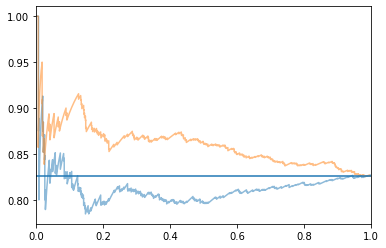

In [62]:
precision, recall, _ = precision_recall_curve(is_aut, num_bases)
plt.plot(recall, precision, alpha=0.5)
precision, recall, _ = precision_recall_curve(is_aut, num_bases-num_notrans_bases)
plt.plot(recall, precision, alpha=0.5)
plt.axhline(np.sum(is_aut)/len(children))
plt.xlim([0, 1])
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


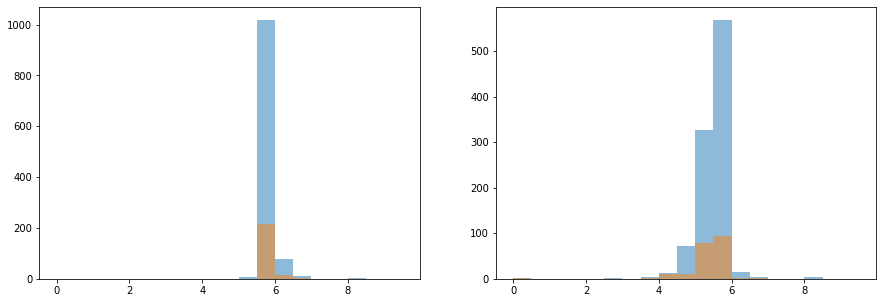

In [63]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.clip(np.log10(num_bases[is_aut]), 0, 10), alpha=0.5, bins=np.arange(0, 10, 0.5))
plt.hist(np.clip(np.log10(num_bases[is_nt]), 0, 10), alpha=0.5, bins=np.arange(0, 10, 0.5))

plt.subplot(1, 2, 2)
plt.hist(np.clip(np.log10((num_bases-num_notrans_bases)[is_aut]), 0, 10), alpha=0.5, bins=np.arange(0, 10, 0.5))
plt.hist(np.clip(np.log10((num_bases-num_notrans_bases)[is_nt]), 0, 10), alpha=0.5, bins=np.arange(0, 10, 0.5))

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


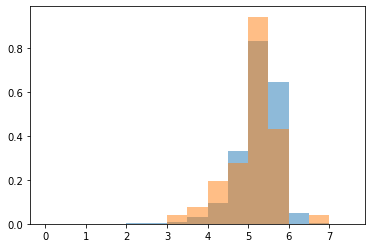

In [90]:
plt.hist(np.log10(num_bases[is_aut]-num_notrans_bases[is_aut]), alpha=0.5, bins=np.arange(0, 8, 0.5), density=True)
plt.hist(np.log10(num_bases[is_nt]-num_notrans_bases[is_nt]), alpha=0.5, bins=np.arange(0, 8, 0.5), density=True)

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: invalid value encountered in double_scalars
  q_ = count * 1. / nobs


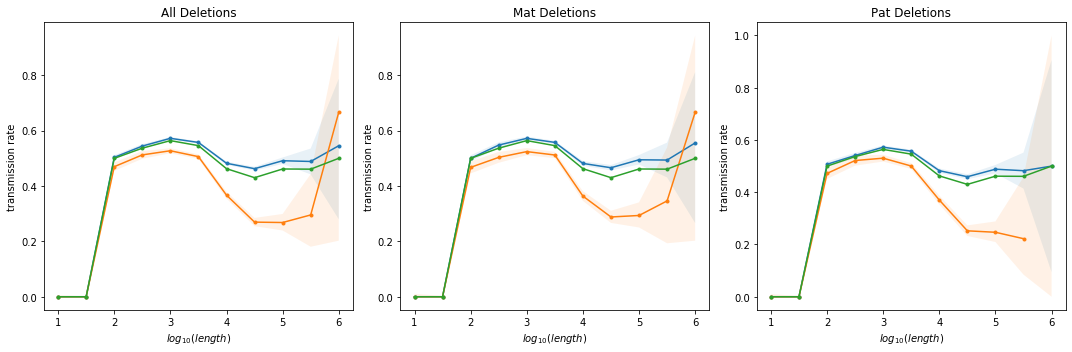

In [91]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(np.arange(1, 6.5, 0.5), aff_del_n/(aff_del_n+aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(aff_del_n, aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(aff_del_n, aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), unaff_del_n/(unaff_del_n+unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(unaff_del_n, unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(unaff_del_n, unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.subplot(1, 3, 2)
plt.plot(np.arange(1, 6.5, 0.5), mat_aff_del_n/(mat_aff_del_n+mat_aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), mat_unaff_del_n/(mat_unaff_del_n+mat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('Mat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.subplot(1, 3, 3)
plt.plot(np.arange(1, 6.5, 0.5), pat_aff_del_n/(pat_aff_del_n+pat_aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), pat_unaff_del_n/(pat_unaff_del_n+pat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('Pat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.tight_layout()
plt.show()

In [97]:
children_phens = []
in_children_phen = set()

for fam, inds in fam_to_inds.items():
    fam_children = [x for x in inds[2:] if x in individuals]
    if len(fam_children)>0:
        phens = [child_id_to_affected[x] for x in fam_children]
        random.shuffle(phens)
        children_phens.append((fam_children, phens))
        in_children_phen.update(fam_children)
        
print(len(children_phens))

1048


In [98]:
assert np.all([x['child'] in in_children_phen and (x['child'] in children) for x in deletions])
assert np.all([x['child'] in in_children_phen and (x['child'] in children) for x in notrans_deletions])

In [99]:
print(len([d for d in deletions if d['is_mat']]))
print(len([d for d in deletions if d['is_pat']]))

62368
63475


In [108]:
# result could be due to family size, so try a permutation test

#bins = np.quantile([x['length'] for x in deletions], np.arange(0, 1.2, 0.2))
bins = [10**x for x in np.arange(2.5, 6, 0.5)] + [10**9]
print(bins)
num_permutations = 1000

permute_pvalues = np.ones((len(bins)-1, num_permutations))
mat_permute_pvalues = np.ones((len(bins)-1, num_permutations))
pat_permute_pvalues = np.ones((len(bins)-1, num_permutations))

del_length = np.array([x['length'] for x in deletions])
notrans_del_length = np.array([x['length'] for x in notrans_deletions])

del_is_mat = np.array([x['is_mat'] for x in deletions])
del_is_pat = np.array([x['is_pat'] for x in deletions])
notrans_del_is_mat = np.array([x['is_mat'] for x in notrans_deletions])
notrans_del_is_pat = np.array([x['is_pat'] for x in notrans_deletions])

def calculate_pvalues(aff, min_length, max_length):
    del_is_aff = np.array([aff[x['child']]=='2' for x in deletions])
    del_is_unaff = np.array([aff[x['child']]=='1' for x in deletions])
    notrans_del_is_aff = np.array([aff[x['child']]=='2' for x in notrans_deletions])
    notrans_del_is_unaff = np.array([aff[x['child']]=='1' for x in notrans_deletions])
    
    aff_trans = np.sum(del_is_aff & (del_length>=min_length) & (del_length<max_length))
    unaff_trans = np.sum(del_is_unaff & (del_length>=min_length) & (del_length<max_length))
    aff_notrans = np.sum(notrans_del_is_aff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
    unaff_notrans = np.sum(notrans_del_is_unaff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
   
    #print([[aff_trans, aff_notrans], [unaff_trans, unaff_notrans]])
    pvalue = stats.chi2_contingency([[aff_trans, aff_notrans], [unaff_trans, unaff_notrans]])[1]
        
    aff_trans = np.sum(del_is_mat & del_is_aff & (del_length>=min_length) & (del_length<max_length))
    unaff_trans = np.sum(del_is_mat & del_is_unaff & (del_length>=min_length) & (del_length<max_length))
    aff_notrans = np.sum(notrans_del_is_mat & notrans_del_is_aff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
    unaff_notrans = np.sum(notrans_del_is_mat & notrans_del_is_unaff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
    mat_pvalue = stats.chi2_contingency([[aff_trans, aff_notrans], [unaff_trans, unaff_notrans]])[1]
        
    aff_trans = np.sum(del_is_pat & del_is_aff & (del_length>=min_length) & (del_length<max_length))
    unaff_trans = np.sum(del_is_pat & del_is_unaff & (del_length>=min_length) & (del_length<max_length))
    aff_notrans = np.sum(notrans_del_is_pat & notrans_del_is_aff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
    unaff_notrans = np.sum(notrans_del_is_pat & notrans_del_is_unaff & (notrans_del_length>=min_length) & (notrans_del_length<max_length))
    pat_pvalue = stats.chi2_contingency([[aff_trans, aff_notrans], [unaff_trans, unaff_notrans]])[1]
    
    return pvalue, mat_pvalue, pat_pvalue
    
for j in range(num_permutations):
    new_child_id_to_affected = dict()
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        new_child_id_to_affected.update(list(zip(fam_children, phens)))
            
    for bin_index in np.arange(len(bins)-1):
        permute_pvalues[bin_index, j], mat_permute_pvalues[bin_index, j], pat_permute_pvalues[bin_index, j] = calculate_pvalues(new_child_id_to_affected, bins[bin_index], bins[bin_index+1])
        
            
    if j%100==0:
        print(j, end=' ')
    
        

[316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000000]
0 100 200 300 400 500 600 700 800 900 

In [109]:
pvalues = np.ones((len(bins)-1,))
mat_pvalues = np.ones((len(bins)-1,))
pat_pvalues = np.ones((len(bins)-1,))

for bin_index in np.arange(len(bins)-1):
    pvalue, mat_pvalue, pat_pvalue = calculate_pvalues(child_id_to_affected, bins[bin_index], bins[bin_index+1])
    print(pvalue, mat_pvalue, pat_pvalue)

    pvalues[bin_index] = np.sum(permute_pvalues[bin_index, :]<=pvalue)/num_permutations
    mat_pvalues[bin_index] = np.sum(mat_permute_pvalues[bin_index, :]<=mat_pvalue)/num_permutations
    pat_pvalues[bin_index] = np.sum(pat_permute_pvalues[bin_index, :]<=pat_pvalue)/num_permutations
        

6.206286075335979e-05 7.89976271462143e-05 0.09100403063309054
5.69761478121779e-18 1.021589858270721e-10 9.35392318270416e-09
3.5614005291314526e-29 2.2787388088725866e-12 1.1800816842184206e-18
1.0738343258722811e-58 7.282962763746981e-31 1.6549566248756885e-29
6.861422263664011e-98 7.30928166509581e-41 3.0324969439059132e-59
2.1230417476826417e-34 1.0960375344745703e-13 2.380546827919644e-22
0.015435553963139753 0.21533950094084614 0.034946142509954314


In [110]:
print(bins)
print(pvalues)
print(mat_pvalues)
print(pat_pvalues)

[316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000000]
[0.87  0.689 0.5   0.048 0.123 0.504 0.382]
[0.392 0.756 0.703 0.012 0.1   0.626 0.409]
[0.947 0.477 0.247 0.289 0.283 0.384 0.582]


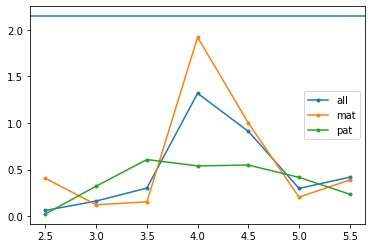

In [111]:
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pvalues, 10**-4, 1)), marker='.', label='all')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(mat_pvalues, 10**-4, 1)), marker='.', label='mat')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pat_pvalues, 10**-4, 1)), marker='.', label='pat')
plt.legend()
plt.axhline(-np.log10(0.05/len(pvalues)))
plt.show()

# Create matrix for GLRM 

In [ ]:
print(len(children))

In [17]:

del_matrices = []

for chrom in [str(x) for x in range(1, 23)]:
    chrom_deletions = [d for d in deletions if d['chrom']==chrom]
    chrom_notrans_deletions = [d for d in notrans_deletions if d['chrom']==chrom]
    
    endpoints = [d['start_pos'] for d in chrom_deletions] 
    endpoints += [d['start_pos']-1 for d in chrom_deletions]
    endpoints += [d['end_pos'] for d in chrom_deletions]
    endpoints += [d['end_pos']-1 for d in chrom_deletions]
    endpoints = sorted(set(endpoints))
    endpoint_to_index = dict([(x, i) for i, x in enumerate(endpoints)])
    
    del_matrix = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        del_matrix[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    del_matrices.append(del_matrix)
    
del_matrix = np.hstack(del_matrices)
print(del_matrix.shape)

(6727, 6103)


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(del_matrix, aspect='auto')
plt.show()

In [ ]:
plt.hist(np.clip(np.sum(del_matrix, axis=0), None, 10))
plt.show()

# Predict ASD

In [37]:
X = np.unique(del_matrix, axis=1)
X = X[:, np.sum(X, axis=0)>0]
X = np.hstack((np.ones((len(children), 1)), X))
print(X.shape)


(6727, 1828)


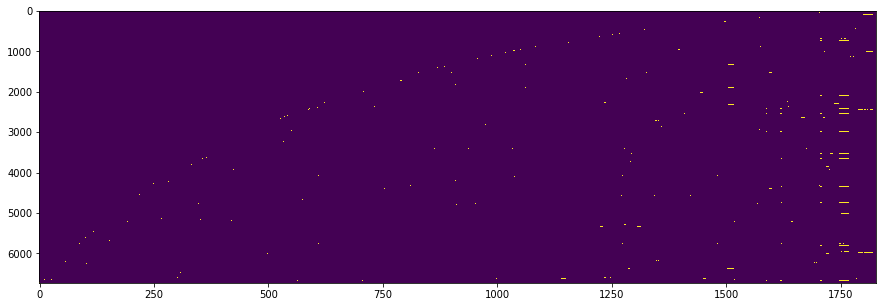

In [38]:
plt.figure(figsize=(15, 5))
plt.imshow(X, aspect='auto')
plt.show()

In [39]:
#X, indices = np.unique(X, axis=0, return_index=True)
#
#y = np.array([child_id_to_affected[x]=='2' for x in children])
#y = y[indices]
#print(X.shape)

In [40]:
y = np.array([child_id_to_affected[x]=='2' for x in children])

In [ ]:
import statsmodels.api as sm

print(X.shape, y.shape)
logit_mod = sm.Logit(y, X)

logit_res = logit_mod.fit_regularized(method='l1', alpha=10)
print(logit_res.summary())

(6727, 1828) (6727,)


# try GLRM using G + P

In [18]:
phen_data = np.zeros((len(children), 40))
with open('../phenotypes/spark/scq.csv', 'r') as f:
    header = next(f).split(',')
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] in child_to_index:
            child_index = child_to_index[pieces[0]]
            phen_data[child_index, :] = [1 if x=='1' else -1 if x=='0' else 0 for x in pieces[11:51]]

In [19]:
phen_data[phen_data==0] = np.nan

In [20]:
from pyglrm import glrm, observations
g = glrm(n_components=2)
g.fit_impute(A)
g.get_hyperprams()

RuntimeError: PyJulia does not support Julia < 0.7 anymore